Sample edges:
          user_id  product_id  rating
0  A2VE83MZF98ITY  0827229534       5
1  A11NCO6YTE4BTJ  0738700797       5
2  A3IGHTES8ME05L  0738700797       5
3   AUEZ7NVOEHYRY  0486220125       5
4  A32Z5HQGTG5V49  0486220125       4
Total edges extracted: 1,275,502
Original network — Nodes: 569,435, Edges: 1,113,195

Island network — Nodes: 185,815, Edges: 614,631

--- Island Network Summary ---
Number of nodes: 185,815
Number of edges: 614,631
Density: 0.0000  # fraction of possible edges present
Average degree: 6.62
Number of connected components: 1


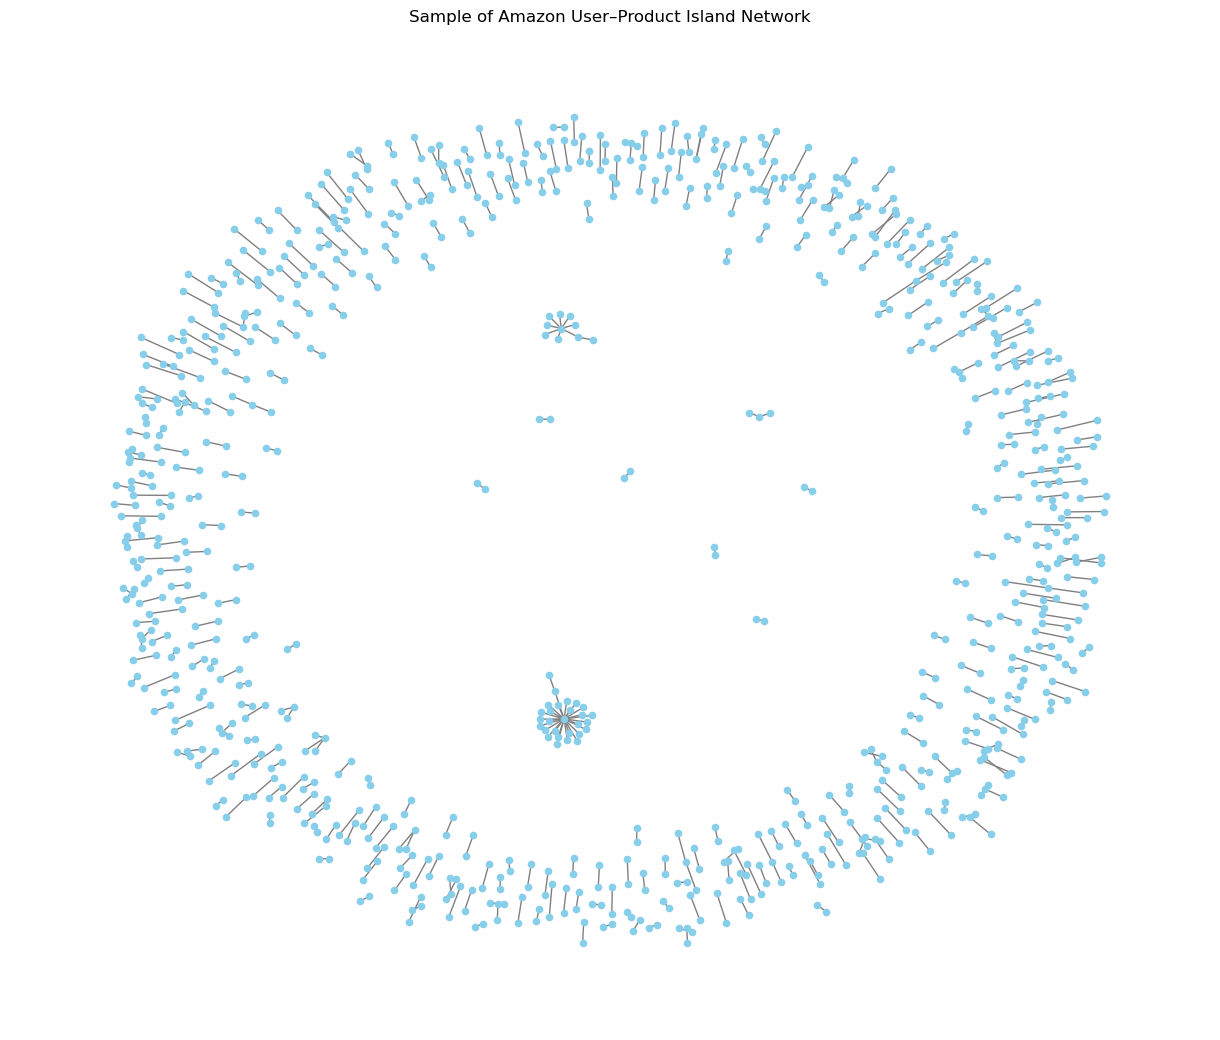


--- Network Interpretation Summary ---

The reduced “island” network highlights two distinct groups: users and products.
The user group primarily consists of active, engaged reviewers who have given multiple high ratings (4 or 5),
representing the core community of positive contributors on Amazon.
The product group contains popular, highly rated items that have received strong reviews from many different users,
forming dense clusters that likely represent specific product niches or categories.
Together, the network reveals a cohesive core where satisfied users interact with well-liked products,
illustrating the strongest and most meaningful relationships within the broader Amazon marketplace.



In [6]:
# import gzip
import re
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import random

"""
Dataset Source:
Stanford Network Analysis Project (SNAP)
https://snap.stanford.edu/data/amazon-meta.html

This script:
- Parses the Amazon metadata file (amazon-meta.txt.gz)
- Builds a bipartite user–product network
- Applies the island method to reduce the network by filtering strong ties (rating ≥ 4)
- Extracts the largest cohesive subnetwork
- Provides summary statistics and a visualization of the resulting island
"""

# =====================================================
# Step 1 : Define the file path
# =====================================================
file_path = r"C:\Users\hotga\Documents\Data 620\project2\amazon-meta.txt.gz"

# =====================================================
# Step 2: Parse the amazon-meta.txt.gz file
# =====================================================
# I extracted a clean list of edges in the form (user_id, product_id, rating)
# The original file is semi-structured text, so I used regex to extract info
data = []
with gzip.open(file_path, "rt", encoding="latin-1") as f:
    asin = None  # current product ASIN
    for line in f:
        line = line.strip()
        
        # Detect product ASIN line
        if line.startswith("ASIN:"):
            asin = line.split("ASIN:")[1].strip()
        
        # Detect review lines, which start with a date (YYYY-MM-DD)
        elif re.match(r"^\d{4}-\d{2}-\d{2}", line):
            # Extract user and rating using regex
            match = re.search(r"cutomer:\s+(\S+).*rating:\s+(\d+)", line)
            if match and asin:
                user, rating = match.groups()
                data.append((user, asin, int(rating)))

# I converted the list of edges into a pandas DataFrame
edges = pd.DataFrame(data, columns=["user_id", "product_id", "rating"])
print("Sample edges:")
print(edges.head())
print(f"Total edges extracted: {len(edges):,}")

# =====================================================
# Step 3: Build bipartite graph
# =====================================================
# Bipartite graph: two node types (users, products), edges = reviews
B = nx.Graph()
for row in edges.itertuples(index=False):
    B.add_edge(row.user_id, row.product_id, weight=row.rating)

print(f"Original network — Nodes: {B.number_of_nodes():,}, Edges: {B.number_of_edges():,}")
# Many nodes and edges may make visualization impossible in the current format

# =====================================================
# Step 4: Apply the Island Method
# =====================================================
# The island method keeps only "strong" ties (edges above a weight threshold)
# I choose rating >= 4 as strong
threshold = 4
strong_edges = [(u, v, d) for u, v, d in B.edges(data=True) if d["weight"] >= threshold]

# Build the reduced graph (initial island)
B_island = nx.Graph()
B_island.add_edges_from(strong_edges)

# Removed low-degree nodes: k-core ensures nodes have at least 2 strong ties
B_island = nx.k_core(B_island, k=2)

# Kept only the largest connected component to isolate main cohesive island
largest_cc = max(nx.connected_components(B_island), key=len)
B_island = B_island.subgraph(largest_cc).copy()

print(f"\nIsland network — Nodes: {B_island.number_of_nodes():,}, Edges: {B_island.number_of_edges():,}")

# =====================================================
# Step 5: Summary Statistics
# =====================================================
# Provides numerical description of the reduced network
print("\n--- Island Network Summary ---")
print(f"Number of nodes: {B_island.number_of_nodes():,}")
print(f"Number of edges: {B_island.number_of_edges():,}")
print(f"Density: {nx.density(B_island):.4f}  # fraction of possible edges present")
print(f"Average degree: {sum(dict(B_island.degree()).values()) / B_island.number_of_nodes():.2f}")
print(f"Number of connected components: {nx.number_connected_components(B_island)}")

# =====================================================
# Step 6: Visualization (sampled)
# =====================================================
# Full network is too large to visualize, so sample up to 500 edges
sample_edges = random.sample(list(B_island.edges()), min(500, B_island.number_of_edges()))
G_sample = B_island.edge_subgraph(sample_edges).copy()

# Spring layout: visually places nodes with force-directed spacing
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G_sample, k=0.1, seed=42)  # k controls spacing
nx.draw(
    G_sample, pos,
    node_size=20,
    node_color='skyblue',
    edge_color='gray',
    with_labels=False
)
plt.title("Sample of Amazon User–Product Island Network")
plt.show()

# =====================================================
# Analysis
# =====================================================

Analysis = """
The reduced “island” network highlights two distinct groups: users and products.
The user group primarily consists of active, engaged reviewers who have given multiple high ratings (4 or 5),
representing the core community of positive contributors on Amazon.
The product group contains popular, highly rated items that have received strong reviews from many different users,
forming dense clusters that likely represent specific product niches or categories.
Together, the network reveals a cohesive core where satisfied users interact with well-liked products,
illustrating the strongest and most meaningful relationships within the broader Amazon marketplace.
"""

print("\n--- Network Interpretation Summary ---")
print(Analysis)
